<a href="https://colab.research.google.com/github/Theedon/AIAgentDemos/blob/main/Expert_Swarm_LanggraphBabyAGI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
!pip install langgraph langchain_openai langchain_community langchain_core langchain_google_community redis langchain_core

In [2]:
import os
from google.colab import userdata

os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('AZURE_OPENAI_ENDPOINT')
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('AZURE_OPENAI_API_KEY')
os.environ["OPENAI_API_VERSION"] = userdata.get('OPENAI_API_VERSION')
os.environ["DEPLOYMENT_NAME"] = userdata.get('DEPLOYMENT_NAME')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_CSE_ID"] = userdata.get('GOOGLE_CSE_ID')

## Required Classes and Functions

In [3]:
question_1="I am travelling to Hoboken, please create an itinerary for three days, I hate swimming but love meeting people and climbing and dancing and clubing"

# question_3 = """
# How can we design an AI-powered wearable for personal health monitoring? Provide a prioritized plan that balances advanced sensor technology, seamless user experience, secure data handling, and a viable business model."""

# question_2 = """
# You are tasked with designing a comprehensive strategy for launching an innovative AI-driven personal finance management platform. Your final deliverable should address the following key areas:

# 1. **Technical Architecture:**
#    - Propose a robust technical infrastructure that supports scalability, high performance, and integration with third-party financial APIs.
#    - Outline the AI capabilities that will drive personalized financial insights and automation.

# 2. **User Experience & Design:**
#    - Detail an intuitive, user-friendly interface design that makes complex financial data accessible.
#    - Map out the user journey and key interaction points to ensure engagement and ease-of-use.

# 3. **Business Strategy:**
#    - Develop a business model including market analysis, competitive positioning, and monetization strategies.
#    - Project potential ROI and outline clear value propositions for both users and stakeholders.

# 4. **Legal & Regulatory Compliance:**
#    - Identify relevant legal, regulatory, and compliance challenges specific to financial services and data privacy.
#    - Propose measures to ensure adherence to these standards.

# 5. **Cybersecurity & Data Privacy:**
#    - Recommend cybersecurity protocols and data privacy measures to protect user information and ensure trust.
#    - Address potential threats and mitigation strategies.

# 6. **Data Analytics & Insights:**
#    - Design a strategy for leveraging data analytics and machine learning to extract actionable insights from user data.
#    - Explain how these insights will drive personalization and improve overall platform performance.

# Your task is to synthesize these diverse perspectives into a cohesive, prioritized strategy. Break down the problem into actionable tasks, ensuring that each component is addressed thoroughly. The final output should be a clear, organized, and integrated plan that details the steps required to launch the platform successfully.
# """

In [4]:
from langchain_openai import AzureChatOpenAI

model = AzureChatOpenAI(
    azure_deployment=os.environ["DEPLOYMENT_NAME"],
    api_version=os.environ["OPENAI_API_VERSION"],
)

In [5]:
from langchain_core.tools import StructuredTool
from langchain_google_community import GoogleSearchAPIWrapper

google_search_tool = GoogleSearchAPIWrapper()
google_search = StructuredTool.from_function(
    name="google_search",
    description="Search Google for recent results.",
    func=google_search_tool.run,
    return_direct=False,
)

tools = [google_search]
tool_dict = {t.name: t for t in tools}

In [6]:
from pydantic import BaseModel, Field
from typing import List, Dict, Optional, TypedDict, Annotated, Union, Any

class TaskCreation(BaseModel):
    tasks: List[str] = Field(..., description="List of tasks needed to achieve goal")

class ValidationResult(BaseModel):
    valid: bool = Field(..., description="Whether tasks achieve objective")
    feedback: Optional[str] = Field(None, description="Improvement suggestions")

class FinalResponse(BaseModel):
    summary: str = Field(..., description="Comprehensive response to objective")

class AgentState(TypedDict):
    objective: str
    task_queue: List[Dict]
    completed_tasks: List[Dict]
    failed_tasks: List[Dict]
    current_task: Optional[Dict]
    iteration: int
    max_iterations: int
    task_id_counter: int
    context: Dict[str, Any]
    agent_memory: List[dict]
    validation_approved: bool|None
    validation_feedback: Optional[str]
    validation_attempts: int
    final_response: Optional[str]

In [7]:
from langchain_core.language_models import BaseLanguageModel
from typing import List
from pydantic import BaseModel, Field


class ExpertResponse(BaseModel):
  expert_name: str = Field(..., description="Name of the expert")
  contribution: str = Field(..., description="The contribution of the expert")


class ExpertAgent():
  def __init__(self, role: str, llm: BaseLanguageModel, job_description: str):
    self.role = role
    self.llm = llm
    self.job_description = job_description

  def __repr__(self):
      return f"ExpertAgent(role='{self.role}', job_description='{self.job_description[:50]}...')"

  def contribute(self, context: str) -> ExpertResponse:
    prompt: str = (
    f"Your name is {self.role}. You are an expert in {self.role} with a job description of {self.job_description}. Given the following context, "
    "do the task/objective you were asked to in the context:\n\n"
    f"{context}\n\n"
    "Your response:"
    )

    structured_llm = self.llm.with_structured_output(ExpertResponse)

    response: ExpertResponse = structured_llm.invoke(
        [
            SystemMessage(
                content=prompt
            )
        ]
    )
    return response

In [8]:
from typing import List, Any
from langchain_core.messages import SystemMessage

class MultiExpertCollaborator:
    def __init__(self, experts: list[ExpertAgent]):
        self.experts = experts

    def aggregate_contributions(self, contributions: List[ExpertResponse]) -> str:
        aggregated = "\n\n".join(
            [f"{con.expert_name} says:\n{con.contribution}" for con in contributions]
        )
        return aggregated

    def collaborate(self, context: str) -> str:
        contributions = []
        for expert in self.experts:
            contribution = expert.contribute(context)
            contributions.append(contribution)
        final_response = self.aggregate_contributions(contributions)
        return final_response

    def synthesize_response(
        self,
        initial_prompt: str,
        structured_llm: Any,
        meta_prompt: str = "Based on the above expert insights, generate an optimized final response. Ensure that you return it in the exact format that each of them handed it off to you.",
        name: str="Lola"
    ) -> Any:
        meta_template = """
        Your name is Lola, the aggregator and mediator expert. You are never needed to provide new information, just to aggregate and synthesize information from other experts
                Aggregated Expert Input:
        {aggregated_expert_response}

        """
        meta_template += meta_prompt

        aggregated_expert_response = self.collaborate(initial_prompt)
        print("*"*10)
        print(aggregated_expert_response)
        print("*"*10)

        meta_prompt = meta_template.format(
            aggregated_expert_response=aggregated_expert_response
        )

        response = structured_llm.invoke([SystemMessage(content=meta_prompt)])
        return response

In [23]:
from typing import List
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage
from langchain_core.language_models import BaseLanguageModel

class GeneratedExpert(BaseModel):
    role: str = Field(..., description="Role of expert relevant to the objective")
    job_description: str = Field(..., description="Job description of expert relevant to the objective")

class GeneratedExperts(BaseModel):
    experts: List[GeneratedExpert] = Field(..., description="List of experts relevant to the objective")

# The power is in the prompt here. Currently I have set it to return the minimum most efficient number of agents possible but I have tried to force it to create max_experts agents too and that works fine albeit more resource consuming
def generate_experts(model: BaseLanguageModel, objective: str, max_experts: int = 4, min_experts: int = 1) -> List[ExpertAgent]:
    # Create a prompt that instructs the LLM to generate a list of experts.
    prompt_text = f"""
    Identify the most suitable expert agents for the given objective.

    Objective: {objective}

    Select only the experts whose knowledge and skills are most relevant to achieving the objective.
    - The maximum number of experts is {max_experts}, but choose the **minimum** required based on task complexity.
    - Return at least **{min_experts} expert**, but avoid unnecessary roles.

    Return the result in **JSON format** as follows:
    {{
        "experts": [
            {{"role": "Expert Role 1", "job_description": "Expert Role 1 Description"}},
            {{"role": "Expert Role 2", "job_description": "Expert Role 2 Description"}}
        ]
    }}
    """

    structured_llm = model.with_structured_output(GeneratedExperts)
    response = structured_llm.invoke(prompt_text)

    expert_agents = [ExpertAgent(role=agent.role, llm=model, job_description=agent.job_description) for agent in response.experts]

    return expert_agents

In [24]:
obj1 = "Find out why Test Time Scaling works so well and helps Shallow LLMs beat Dense Networks that possess"
generate_experts(model=model, objective=obj1, max_experts=5)

[ExpertAgent(role='Machine Learning Researcher', job_description='Focuses on neural network architectures and mechan...'),
 ExpertAgent(role='Neural Network Architect', job_description='Specializes in designing efficient neural network ...'),
 ExpertAgent(role='AI Theorist', job_description='Examines theoretical foundations of LLMs and Dense...'),
 ExpertAgent(role='Computational Systems Analyst', job_description='Studies computational complexity and efficiency in...')]

In [25]:
obj2 = "How do intersecting narratives of history, literature, and cultural memory shape contemporary debates on identity and power?"
generate_experts(model=model, objective=obj2, min_experts=20, max_experts=20)

[ExpertAgent(role='Cultural Historian', job_description='Explores the development of societal beliefs and p...'),
 ExpertAgent(role='Comparative Literature Scholar', job_description='Analyzes literature from different cultures to und...'),
 ExpertAgent(role='Memory Studies Researcher', job_description='Examines how collective memory influences current ...'),
 ExpertAgent(role='Postcolonial Theorist', job_description='Investigates the impact of colonial history on mod...'),
 ExpertAgent(role='Sociocultural Anthropologist', job_description='Studies cultural practices and beliefs to uncover ...'),
 ExpertAgent(role='Historian of Ideas', job_description='Traces the evolution of cultural and philosophical...'),
 ExpertAgent(role='Cultural Critic', job_description='Evaluates cultural texts and events to provide ins...'),
 ExpertAgent(role='Identity Politics Researcher', job_description='Explores how cultural, social, and political facto...'),
 ExpertAgent(role='Intersectionality Expert', job

In [22]:
obj3 = "How can interdisciplinary collaboration shape robust frameworks that balance technological innovation, financial stability, and ethical governance in our interconnected world?"
generate_experts(model=model, objective=obj3, max_experts=10)

[ExpertAgent(role='Technological Innovation Strategist', job_description='Specializes in fostering innovation within organiz...'),
 ExpertAgent(role='Financial Systems Analyst', job_description='Analyzes and forecasts financial data to ensure lo...'),
 ExpertAgent(role='Ethical Governance Specialist', job_description='Focuses on the application of ethical principles t...'),
 ExpertAgent(role='Interdisciplinary Collaboration Facilitator', job_description='Expertise in bringing together diverse teams to en...')]

In [19]:
generate_experts(model=model, objective=question_1, max_experts=20)

[ExpertAgent(role='Travel Itinerary Specialist', job_description='An expert in designing detailed travel itineraries...'),
 ExpertAgent(role='Social and Event Coordinator', job_description='Skilled in organizing and recommending local event...'),
 ExpertAgent(role='Adventure Guide', job_description='Specializes in finding climbing venues and adventu...')]

## Create Initial Task

In [ ]:
from langchain_core.messages import SystemMessage
from typing import Dict

create_initial_tasks_prompt = """

Objective: {objective}

Available tools: {tools}

validation_feeback: {validation_feedback}

Your job is to create a list of initial tasks to be accomplished in order to in order to achieve the objective
NOTE When generating tasks:
If a question can be responded to immediately just create a single tasks that achieves the objective.

ENSURE that none of the tasks are vague.

Take the validation feedback into account.

Generate initial tasks:"""

def create_initial_tasks(state: AgentState) -> Dict:
    structured_llm = model.with_structured_output(TaskCreation)

    tools_str = ", ".join(tool_dict.keys())
    validation_feedback = state.get("validation_feedback", "None")

    task_prompt_content = create_initial_tasks_prompt.format(
        objective=state["objective"],
        tools=tools_str,
        validation_feedback=validation_feedback
    )
    task_prompt = SystemMessage(content=task_prompt_content)



    meta_prompt = """Based on the above expert insights, generate an optimized list of tasks to achieve the objective.
    Select only the best, most actionable tasks."""


    multi_expert = MultiExpertCollaborator(experts=generate_experts(model, state["objective"], max_experts=10))
    response = multi_expert.synthesize_response(initial_prompt=task_prompt.content, structured_llm=structured_llm)

    tasks = [{
        "task_id": state["task_id_counter"] + i,
        "description": task,
        "attempts": 0,
        "status": "pending"
    } for i, task in enumerate(response.tasks, start=1)]

    return {
        "task_queue": tasks,
        "task_id_counter": state["task_id_counter"] + len(tasks),
        "validation_approved": False
    }

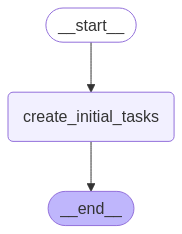

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph
from langgraph.constants import START, END
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(AgentState)
builder.add_node("create_initial_tasks", create_initial_tasks)

builder.add_edge(START, "create_initial_tasks")
builder.add_edge("create_initial_tasks", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
import random
thread = {"configurable": {"thread_id": str(random.randint)}}
initial_state = AgentState(
            objective=question_1,
            task_queue=[],
            completed_tasks=[],
            failed_tasks=[],
            current_task=None,
            iteration=0,
            max_iterations=5,
            task_id_counter=0,
            context={}
        )

for event in graph.stream(initial_state, thread, stream_mode="values"):
    tasks = event.get('task_queue', None)

    if tasks:
        for task in tasks:
            print(f"Task ID: {task['task_id']}, : {task['description']}")

**********
Travel Itinerary Specialist says:
1. Research climbing facilities and opportunities in Hoboken to include in the itinerary. 
2. Explore nightlife and clubbing venues in Hoboken that offer vibrant social atmospheres and dance events. 
3. Investigate community events, gatherings, or venues in Hoboken that are conducive to meeting new people and socializing. 
4. Draft a three-day itinerary incorporating climbing activities, nightlife, dance events, and social opportunities in Hoboken. 
5. Create a schedule that balances the inclusion of these activities while considering geographical and logistical aspects of Hoboken.

Event Planner says:
1. Research and list top venues in Hoboken for dancing and clubbing.
2. Check the schedule of events or parties at these venues for the next three days.
3. Identify popular spots for socializing and meeting new people in Hoboken.
4. Find best climbing spots or gyms with indoor climbing facilities in Hoboken.
5. Create a detailed itinerary incl

In [ ]:
# graph.get_state(thread)

## Validate Tasks

In [ ]:
task_validation_prompt = """
Objective: {objective}
Existing Context: {context}
Available tools: {tools}
Proposed Tasks: {task_descriptions}

Do these tasks fully achieve the objective given current context? Provide feedback.
"""

def format_context(context: Dict) -> str:
        if not context:
            return "No context available yet"
        return "\n".join(
            f"- {key}: {value['description']}\n  Result: {value['result'][:200]}..."
            for key, value in context.items()
        )

def validate_tasks(state: AgentState) -> Dict:
    task_descriptions = [t["description"] for t in state["task_queue"]]

    structured_llm = model.with_structured_output(ValidationResult)

    new_attempts = state["validation_attempts"]

    # meta_prompt = """Based on the above expert contributions, synthesize a final response that integrates their diverse insights into one coherent and actionable summary. Return it in the format that each of them presented it.
    # """

    task_prompt_content = task_validation_prompt.format(objective=state["objective"], context=format_context(state["context"]), task_descriptions=task_descriptions, tools=tool_dict.keys())
    task_prompt = SystemMessage(content=task_prompt_content)

    multi_expert = MultiExpertCollaborator(experts=generate_experts(model, state["objective"], max_experts=4))
    response = multi_expert.synthesize_response(initial_prompt=task_prompt.content, structured_llm=structured_llm)

    new_attempts += 1

    return {
        "validation_approved": response.valid,
        "validation_feedback": response.feedback,
        "validation_attempts": new_attempts
    }

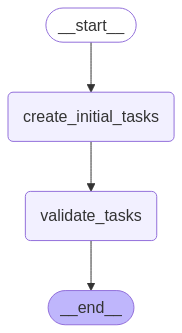

In [ ]:
builder = StateGraph(AgentState)
builder.add_node("create_initial_tasks", create_initial_tasks)
builder.add_node("validate_tasks", validate_tasks)

builder.add_edge(START, "create_initial_tasks")
builder.add_edge(
    "create_initial_tasks",
            "validate_tasks",

        )
builder.add_edge("validate_tasks", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
import random
thread = {"configurable": {"thread_id": str(random.randint)}}

initial_state = AgentState(
            objective=question_1,
            task_queue=[],
            completed_tasks=[],
            failed_tasks=[],
            current_task=None,
            iteration=0,
            validation_attempts=0,
            max_iterations=5,
            task_id_counter=0,
            context={}
        )

for event in graph.stream(initial_state, thread, stream_mode="values"):
    tasks = event.get('task_queue', None)
    validation = event.get('validation_approved', None)
    validation_feedback = event.get('validation_feedback', None)

    if validation is not None:
        print(f"Validation Approved: {validation}")

    print(validation_feedback)

    if tasks:
        for task in tasks:
            print(f"Task ID: {task['task_id']} : {task['description']}")

None
**********
Travel Planner says:
1. Search for climbing gyms or outdoor climbing sites in Hoboken.
2. Look up social events or networking gatherings happening in Hoboken during the travel dates.
3. Identify clubs or venues with nightlife and dancing options in Hoboken.
4. Verify if there are any guided city tours or meetups for travelers to meet locals.
5. Research restaurants or cafes with communal seating or known for socializing.
6. Compile the activities into a three-day itinerary considering travel distances and time availability.

Local Culture Enthusiast says:
1. Identify popular venues in Hoboken for socializing and dancing, such as local clubs, dance studios, or live music bars. 
2. Research rock climbing gyms or indoor climbing centers in Hoboken or nearby areas for climbing activities. 
3. Explore local community events, fairs, or gatherings happening during the travel period in Hoboken to facilitate meeting people. 
4. Create a detailed daily schedule incorporating thes

## Prioritize Tasks

In [ ]:
def decide_validation(state: AgentState) -> str:
    if state["validation_approved"]:
        return "valid"
    elif state["validation_attempts"] >= state["max_iterations"]:
        return "max_exceeded"
    return "invalid"

def prioritize_tasks(state: AgentState) -> Dict:
    structured_llm = model.with_structured_output(TaskCreation)

    all_tasks = state["task_queue"] + state["failed_tasks"]
    task_descriptions = [t["description"] for t in all_tasks]
    iteration = state["iteration"]

    meta_prompt = """Your task is not to aggregate new ideas but to review the priority order and votes provided by the experts. Analyze the expert suggestions and their associated votes, then produce a final, prioritized list. Ensure the final list is sorted so that the items with the highest consensus and votes appear first.

    """

    task_prompt_content = f"""
    # Objective: {state['objective']}
    # Tasks to prioritize: {task_descriptions}

    # Return sorted tasks by priority (most important first).
    # Add any missing critical tasks.
    # """
    task_prompt = SystemMessage(content=task_prompt_content)

    multi_expert = MultiExpertCollaborator(experts=generate_experts(model, state["objective"], max_experts=4))
    response = multi_expert.synthesize_response(initial_prompt=task_prompt.content, structured_llm=structured_llm, meta_prompt=meta_prompt)

    task_map = {t["description"]: t for t in all_tasks}
    prioritized = []
    for desc in response.tasks:
            if desc in task_map:
                prioritized.append(task_map[desc])
            else:
                prioritized.append({
                    "task_id": state["task_id_counter"],
                   Hi "description": desc,
                    "attempts": 0,
                    "status": "pending"
                })
                state["task_id_counter"] += 1

    return {"task_queue": prioritized, "failed_tasks": [], "iteration": iteration+1}

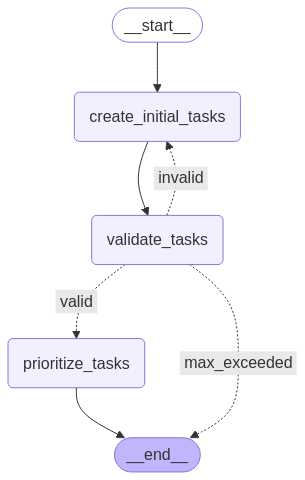

In [ ]:
builder = StateGraph(AgentState)
builder.add_node("create_initial_tasks", create_initial_tasks)
builder.add_node("validate_tasks", validate_tasks)
builder.add_node("prioritize_tasks", prioritize_tasks)

builder.add_edge(START, "create_initial_tasks")
builder.add_edge("create_initial_tasks","validate_tasks")
builder.add_conditional_edges(
    "validate_tasks",
    decide_validation,
    {
        "valid": "prioritize_tasks",
        "invalid": "create_initial_tasks",
        "max_exceeded": END
    }
)
builder.add_edge("prioritize_tasks", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
thread = {"configurable": {"thread_id": str(random.randint)}}

initial_state = AgentState(
            objective=question_1,
            task_queue=[],
            completed_tasks=[],
            failed_tasks=[],
            current_task=None,
            iteration=0,
            validation_attempts=0,
            max_iterations=5,
            task_id_counter=0,
            context={}
        )


for event in graph.stream(initial_state, thread, stream_mode="values"):
    tasks = event.get('task_queue', None)
    validation = event.get('validation_approved', None)
    validation_feedback = event.get('validation_feedback', None)

    if validation is not None:
        print(f"Validation Approved: {validation}")

    print(validation_feedback)

    if tasks:
        for task in tasks:
            print(f"Task ID: {task['task_id']} : {task['description']}")

None
**********
Travel Planner says:
1. Research popular climbing spots in Hoboken and schedule visits. 2. Find local clubs with dancing events in Hoboken and plan nights out. 3. Organize social engagement activities and events to meet new people in Hoboken.

Local Culture Guide says:
1. Research popular spots in Hoboken for dancing and clubbing. 
2. Identify local events happening in Hoboken over the next three days where the traveler can meet people. 
3. Find locations in or near Hoboken that offer climbing activities. 
4. Compile a three-day itinerary incorporating dancing, clubbing, local events, and climbing opportunities. 
5. Ensure recommended activities and events align with the traveler's interests and preferences.

Outdoor Adventure Specialist says:
Create a detailed 3-day itinerary for a trip to Hoboken focusing on climbing, meeting people, dancing, and clubbing.
**********
Validation Approved: False
None
Task ID: 1 : Research popular climbing spots in Hoboken and schedule v

In [ ]:
# graph.get_state(thread)

StateSnapshot(values={'objective': 'I am travelling to Hoboken, please create an itinerary for three days, I hate swimming but love meeting people and climbing and dancing and clubbing', 'task_queue': [{'task_id': 6, 'description': 'Compile a three-day itinerary incorporating dancing, clubbing, local events, and climbing opportunities.', 'attempts': 0, 'status': 'pending'}, {'task_id': 7, 'description': "Ensure recommended activities and events align with the traveler's interests and preferences.", 'attempts': 0, 'status': 'pending'}, {'task_id': 1, 'description': 'Research popular climbing spots in Hoboken and schedule visits.', 'attempts': 0, 'status': 'pending'}, {'task_id': 2, 'description': 'Find locations in or near Hoboken that offer climbing activities.', 'attempts': 0, 'status': 'pending'}, {'task_id': 3, 'description': 'Identify local clubs with dancing events in Hoboken and plan nights out.', 'attempts': 0, 'status': 'pending'}, {'task_id': 4, 'description': 'Research popula

## Execute Task

In [ ]:
def check_iteration_limit(state: AgentState) -> str:
        return "stop" if state["iteration"] >= state["max_iterations"] else "continue"

def decide_after_execution(state: AgentState) -> str:
        if not state["task_queue"] and not state["failed_tasks"]:
            return "complete"
        if state.get("current_task", {}).get("status") == "failed":
            return "fail"
        return "continue"

In [ ]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

system_prompt = """
You are an AI agent working on: {objective}
Available Tools: {tools}

Current Context:
{context}

Execute the given task
"""
agent = None

def create_agent(state: AgentState):
    global agent
    if not agent:
        memory = MemorySaver()
        agent = create_react_agent(
            model=model,
            tools=tools,
            prompt=system_prompt.format(objective=state["objective"], tools=tool_dict.keys(), context=format_context(state["context"])),
            name="react",
            checkpointer=memory,
        )

        return agent
    return agent

def execute_task(state: AgentState) -> Dict:
    agent_executor = create_agent(state)

    if not state["task_queue"]:
            return {}

    task = state["task_queue"].pop(0)
    state["current_task"] = task
    task["attempts"] += 1

    try:
            # Prepare agent input with context
            task_prompt =f"""
Objective: {state['objective']}
Current Task: {task['description']}
"""

            message = HumanMessage(content=task_prompt)

            # Execute the react agent
            result = agent_executor.invoke(
                ({"messages": task_prompt}),
                config={
                    "configurable": {"thread_id": state["objective"]},
                },
            )

            return finalize_task(state, result["messages"][-1].content)


    except Exception as e:
            error_msg = f"{type(e).__name__}: {str(e)}"
            return {
                "current_task": {
                    **task,
                    "status": "failed",
                    "error": error_msg
                },
                "failed_tasks": state["failed_tasks"] + [task]
            }

def finalize_task(state: AgentState, answer: str) -> Dict:
        task = state["current_task"]
        context_key = f"task_{task['task_id']}"
        state["context"][context_key] = {
            "description": task["description"],
            "result": answer
        }

        return {
            "completed_tasks": state["completed_tasks"] + [{
                **task,
                "result": answer,
                "status": "completed"
            }],
            "current_task": task
        }

def handle_failure(state: AgentState) -> Dict:
    structured_llm = model.with_structured_output(TaskCreation)

    failed_tasks = [t["description"] for t in state["failed_tasks"]]

    # meta_prompt = """Based on the above expert contributions, synthesize a final response that integrates their diverse insights into one coherent and actionable summary. Return it in the format that each of them presented it.
    # """

    task_prompt_content = f"""
      Objective: {state['objective']}
      Failed tasks: {failed_tasks}

      Generate sub-tasks or alternative approaches to handle these failures.
      """
    task_prompt = SystemMessage(content=task_prompt_content)

    multi_expert = MultiExpertCollaborator(experts=generate_experts(model, state["objective"], max_experts=8))
    response = multi_expert.synthesize_response(initial_prompt=task_prompt.content, structured_llm=structured_llm)


    new_tasks = [{
            "task_id": state["task_id_counter"] + i,
            "description": task,
            "attempts": 0,
            "status": "pending"
        } for i, task in enumerate(response.tasks, 1)]

    return {
            "task_queue": state["task_queue"] + new_tasks,
            "task_id_counter": state["task_id_counter"] + len(new_tasks),
            "failed_tasks": []
        }

In [ ]:
compile_prompt = """SYNTHESIZE FINAL ANSWER:
Objective: {objective}
Completed Tasks: {completed_tasks}

Combine all task results into a comprehensive response that directly addresses the original objective.
Include supporting details and maintain logical flow.

DON"T SUMMARIZE THE RESPONSE.
NOTE: ALWAYS RETURN A DETAILED RESPONSE
"""

def compile_results(state: AgentState) -> Dict:
    structured_llm = model.with_structured_output(FinalResponse)

    completed = "\n".join(
        f"- {task['description']}\n  Result: {task.get('result', 'No result')}"
        for task in state["completed_tasks"]
    )

    # meta_prompt = """Based on the above expert contributions, synthesize a final response that integrates their diverse insights into one coherent and actionable summary. Return it in the format that each of them presented it.
    # """

    task_prompt_content = compile_prompt.format(
            objective=state["objective"],
            completed_tasks=completed
        )
    task_prompt = SystemMessage(content=task_prompt_content)

    multi_expert = MultiExpertCollaborator(experts=generate_experts(model, state["objective"], max_experts=4))
    response = multi_expert.synthesize_response(initial_prompt=task_prompt.content, structured_llm=structured_llm)


    return {"final_response": response.summary}

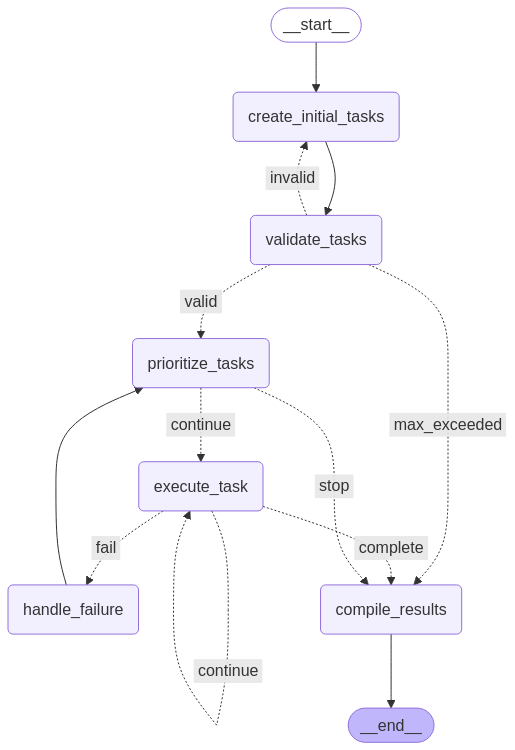

In [ ]:
from langgraph.graph import StateGraph
from langgraph.constants import START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display



builder = StateGraph(AgentState)
builder.add_node("create_initial_tasks", create_initial_tasks)
builder.add_node("validate_tasks", validate_tasks)
builder.add_node("prioritize_tasks", prioritize_tasks)
builder.add_node("execute_task", execute_task)
builder.add_node("handle_failure", handle_failure)
builder.add_node("compile_results", compile_results)

builder.add_edge(START, "create_initial_tasks")
builder.add_edge("create_initial_tasks","validate_tasks")
builder.add_conditional_edges(
    "validate_tasks",
    decide_validation,
    {
        "valid": "prioritize_tasks",
        "invalid": "create_initial_tasks",
        "max_exceeded": "compile_results"
    }
)
builder.add_conditional_edges(
            "execute_task",
            decide_after_execution,
            {"continue": "execute_task", "fail": "handle_failure", "complete": "compile_results"}
        )
builder.add_edge("handle_failure", "prioritize_tasks")
builder.add_conditional_edges(
            "prioritize_tasks",
            check_iteration_limit,
            {"continue": "execute_task", "stop": "compile_results"}
        )
builder.add_edge("compile_results", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
thread = {"configurable": {"thread_id": "f"}}
initial_state = AgentState(
            objective=question_1,
            task_queue=[],
            completed_tasks=[],
            failed_tasks=[],
            current_task=None,
            iteration=0,
            max_iterations=5,
            validation_attempts=0,
            task_id_counter=0,
            context={}
        )

# for event in graph.stream(initial_state, thread, stream_mode="values"):
#     tasks = event.get('task_queue', None)
#     validation = event.get('validation_approved', None)
#     validation_feedback = event.get("validation_feedback", None)

#     if validation is not None:
#         print(f"Validation Approved: {validation}")

#     print(f"validation feeback:{validation_feedback}")

#     if tasks:
#         for task in tasks:
#             print(f"Task ID: {task['task_id']} : {task['description']}")

graph.invoke(initial_state, thread)

**********
Travel Itinerary Planner says:
1. Research popular climbing spots and facilities in Hoboken and create a list. 
2. Identify popular clubs and nightlife venues in Hoboken suitable for dancing and clubbing. 
3. Search for local events or meetups happening during the travel dates in Hoboken to facilitate meeting people. 
4. Arrange an itinerary that includes climbing activities during the daytime, options for meeting people, and engaging nightlife in the evenings over the course of three days.

Local Guide says:
Research top climbing spots in and near Hoboken. Identify social venues like clubs and dance locations that are popular and align with the traveler's interests. Validate the venues and activities with updated information retrieved using google_search to ensure accuracy and current status for inclusion in a 3-day itinerary.

Nightlife & Events Specialist says:
1. Conduct a Google search to identify popular clubs and dance venues in Hoboken that align with the traveler's 

{'objective': 'I am travelling to Hoboken, please create an itinerary for three days, I hate swimming but love meeting people and climbing and dancing and clubbing',
 'task_queue': [{'task_id': 40,
   'description': 'Research and include popular climbing locations within a reasonable distance from Hoboken, aligning with the traveler’s skill level and preferences.',
   'attempts': 0,
   'status': 'pending'},
  {'task_id': 47,
   'description': 'Research climbing locations near Hoboken, including outdoor spots and The Gravity Vault for indoor climbing options.',
   'attempts': 0,
   'status': 'pending'},
  {'task_id': 48,
   'description': 'Consult adventure tour organizers in Hoboken for guided climbing experiences and social mingling opportunities.',
   'attempts': 0,
   'status': 'pending'},
  {'task_id': 46,
   'description': 'Coordinate logistics such as equipment rental, guides, or transport for climbing and hiking activities.',
   'attempts': 0,
   'status': 'pending'},
  {'task_i

In [ ]:
state = graph.get_state(thread)

In [ ]:
print(state.values.get("final_response"))

Welcome to Hoboken, a vibrant city perfect for your interests in meeting people, climbing, dancing, and clubbing over three days! Here's an optimized itinerary combining insights from the Local Tour Guide and Event Coordinator:

### Day 1: Discover, Connect, and Party
- **Morning:** Start your day with breakfast at **La Isla** to meet residents or head to the **Hoboken Farmers' Market** for a social hub experience.
- **Midday:** Engage in an exhilarating climbing session at **Gravity Vault Indoor Rock Gym**, perfect for bonding with fellow climbers.
- **Afternoon:** Explore boutiques and coffee shops and socialize at **Choc O Pain**.
- **Evening:** Enjoy a lively dinner at **Charrito’s** and then dance the night away at **Birch Hoboken**, known for its energetic club scene.

### Day 2: Adventure and Engagement
- **Morning:** Breakfast at **Bluestone Lane Hoboken** with striking conversations.
- **Midday:** Visit the **Hoboken Historical Museum** to mingle with history enthusiasts.
- **

## Evaluation Report

**Agent A:** Our "vanilla" Langgraph BabyAGI agent.  
**Agent B:** The Langgraph BabyAGI agent enhanced with preset Expert Collaborators—specifically, a Technical Expert, Business Expert, and Design Expert.  
**Agent C:** The Langgraph BabyAGI agent that dynamically generates Expert Collaborators based on the specific objectives.

This report summarizes the process and findings of evaluating three AI agents—Agent A, Agent B, and Agent C—tasked with creating a three-day itinerary for a trip to Hoboken. The user provided specific preferences (loves meeting people, climbing, dancing, and clubbing; hates swimming) to guide the agents' responses. The resulting itineraries were then evaluated by four different AI models: Gemini (myself), ChatGPT 03-mini, Claude, and Deepseek R1.

---

## 1. The Challenge

The core task given to Agent A, Agent B, and Agent C was to generate a three-day itinerary for a user traveling to Hoboken. The itinerary needed to cater to the user's specific interests in meeting people, climbing, dancing, and clubbing, while explicitly avoiding any activities involving swimming.


---

## 2. Agent Responses (Brief Summary)

- **Agent A:**  
  Focused on a structured day-by-day plan with dedicated climbing sessions, social meet-ups, and nightlife options, primarily within Hoboken.

- **Agent B:**  
  Provided a detailed itinerary with specific venue names, incorporating climbing, dancing, cultural visits, and food recommendations, but included some locations outside of Hoboken.

- **Agent C:**  
  Offered a well-rounded itinerary emphasizing social interaction at various Hoboken locations, multiple climbing options, and a mix of dancing and clubbing experiences.

---

## 3. Evaluation Process

Each agent's response was independently evaluated by four AI models (Gemini, ChatGPT 03-mini, Claude, and Deepseek R1). Each model employed its own set of criteria to assess the quality, relevance, and overall satisfaction of the generated itineraries.

---
Below was the prompt given to all those agents
```md
I have 3 agents. Agent_A and Agent_B and Agent_C and i gave them both a task which was
question="I am travelling to Hoboken, please create an itinerary for three days, I hate swimming but love meeting people and climbing and dancing and clubbing"

The responses i got from each were
Agent_A => """
Here's a three-day itinerary tailored to your interests in Hoboken:

### Day 1: Climbing and Social Meet-ups
- **Morning:** Start your day at **The Gravity Vault** in Hoboken, a spacious climbing gym with over 120 bouldering routes. It's perfect for enthusiasts looking for a variety of challenges.
- **Afternoon:** Grab lunch at a local café and then join a **YogaRenew 3-mile group run** combined with a 10-minute group stretch to meet fellow fitness enthusiasts.
- **Evening:** Attend one of the local **social events** around Hoboken, such as a community meet-up or a hip-hop social gathering for a relaxed evening where you can meet new people.

### Day 2: Dancing and Clubbing
- **Morning:** Take a leisurely walk around **Maritime Park** for a peaceful start to your day with great views of the city.
- **Afternoon:** Visit **Rumba Cubana** for lunch, a lively spot that often hosts great midday events.
- **Evening:** Head to **Birch Hoboken**, the city's hottest nightclub for dancing. It's known for its live DJs and vibrant atmosphere. Alternatively, try **Madd Hatter** where the tables are cleared out for dancing after 10 PM.

### Day 3: More Climbing & Nightlife
- **Morning:** Return for another session at **The Gravity Vault** to tackle new bouldering routes and meet climbers.
- **Afternoon:** Visit the **Hoboken Public Library** for community events or enroll in a painting class to meet creative locals.
- **Evening:** Dine at **Lua**, a restaurant offering a breathtaking view of the Manhattan skyline.
- **Late Night:** Explore one of the local bars with dance floors such as **The Shannon** or **Tally-Ho** for some casual clubbing scenes and more dancing.

This itinerary blends your love for climbing, dancing, clubbing, and socializing. Enjoy your trip to Hoboken!
"""


Agent_B => Here's a curated three-day itinerary for an exciting trip to Hoboken, ensuring a mix of social activities, climbing, and vibrant nightlife, tailored to your interests:

### Day 1: Arrival and Exploration
- **Morning:** Begin with breakfast at 'Antique Bar & Bakery'. Then, take a walk at 'Pier A Park' to enjoy the views and mingle with locals.
- **Afternoon:** Visit 'Gravity Vault Indoor Rock Gym' in nearby Jersey City for a climbing session. Have lunch at 'La Isla' for delicious Cuban cuisine.
- **Evening:** Start the night at 'Pilsener Haus & Biergarten' and later dance at 'Maxwell's' with live music to engage with the vibrant crowd.

### Day 2: Cultural and Social Exploration
- **Morning:** Eat breakfast at 'O'Bagel', then visit the 'Hoboken Historical Museum'.
- **Afternoon:** Participate in a dance class at 'Garden Street School of Performing Arts'. Grab lunch at 'Zafra Kitchen'.
- **Evening:** Dine at 'Anthony David’s', then head to 'Tally Ho' for dancing and socializing.

### Day 3: Outdoor Adventure and Socializing
- **Morning:** Begin with brunch at 'Court Street', followed by a climb or scenic walk at Liberty State Park.
- **Afternoon:** Visit 'Barsky Gallery' and chat with local artists, then lunch at 'Augustino's'.
- **Evening:** Dine at 'The Madison Bar & Grill' and end the trip dancing at 'Lola's Tapas Bar'.

This itinerary is designed to offer a perfect blend of social interactions, climbing activities, and exhilarating nightlife in Hoboken.

I need you to compare both agents thoroughly to see which one did better and in all expected ramifications for an AI agents and intelligence and result satisfaction. Give a detailed explanation and then finally give the total score over 100

Agent_C = """
Welcome to Hoboken, a vibrant city perfect for your interests in meeting people, climbing, dancing, and clubbing over three days! Here's an optimized itinerary combining insights from the Local Tour Guide and Event Coordinator:

### Day 1: Discover, Connect, and Party
- **Morning:** Start your day with breakfast at **La Isla** to meet residents or head to the **Hoboken Farmers' Market** for a social hub experience.
- **Midday:** Engage in an exhilarating climbing session at **Gravity Vault Indoor Rock Gym**, perfect for bonding with fellow climbers.
- **Afternoon:** Explore boutiques and coffee shops and socialize at **Choc O Pain**.
- **Evening:** Enjoy a lively dinner at **Charrito’s** and then dance the night away at **Birch Hoboken**, known for its energetic club scene.

### Day 2: Adventure and Engagement
- **Morning:** Breakfast at **Bluestone Lane Hoboken** with striking conversations.
- **Midday:** Visit the **Hoboken Historical Museum** to mingle with history enthusiasts.
- **Afternoon:** Opt for more climbing at **BETA Climbing + Fitness** or enjoy **Pier A Park** for community events.
- **Evening:** Dinner at **Amanda's Restaurant** for cozy conversations.
- **Night:** Experience **The Garden at The W Hotel** for cocktails and dance music.

### Day 3: Culture, Relaxation, and Celebration
- **Morning:** Enjoy brunch at **Elysian Cafe** and chat with friendly patrons.
- **Midday:** Participate in a community yoga class at **YogaSpark** Hoboken.
- **Afternoon:** Stroll along the **Hoboken Waterfront Walkway** to relax and meet locals.
- **Evening:** Dinner at **Dolce & Salato** and socialize.
- **Night:** Wrap up at **Lulu’s**, enjoying the rooftop vibe and energetic crowd.

This itinerary ensures you’ll make unforgettable connections, satisfy your love for climbing, and revel in Hoboken's dynamic nightlife. Have an amazing trip!
"""

Compare their responses objectively and thoroughly to see which gave the best response based on high standards
```


---

## 4. Summary of Each Model's Evaluation

### Gemini 2.0 Flash Reasoning Experimental
- **Key Criteria:**  
  Relevance, Specificity, Variety, Logistical Sense, Social Opportunities, Climbing Focus, Dancing/Clubbing Focus, Local Knowledge, Formatting, Tone.
- **Key Findings:**  
  - Agent C excelled in social opportunities and local knowledge.  
  - Agent A provided a solid balance.  
  - Agent B was penalized for suggesting a climbing gym in Jersey City.
- **Final Scores:**  
  - Agent A: 85.5/100  
  - Agent B: 75/100  
  - Agent C: 96/100

### ChatGPT 03-mini
- **Key Criteria:**  
  Tailoring to User Interests, Specificity & Local Relevance, Variety, Cohesion & Flow, Overall Engagement & Creativity.
- **Key Findings:**  
  - Agent C was deemed most balanced and locally tailored.  
  - Agent A was strong on activity details but had some imbalance.  
  - Agent B included off-target cultural spots and geographic inconsistencies.
- **Final Scores:**  
  - Agent C: 92/100  
  - Agent A: 87/100  
  - Agent B: 83/100

### Claude Sonnet 3.7
- **Key Metrics:**  
  Adherence to Preferences, Specificity and Detail, Organization and Structure, Practicality and Feasibility, Creativity and Engagement.
- **Key Findings:**  
  - Agent C demonstrated the best balance of preferences and excellent specificity.  
  - Agent B was detailed but less aligned with core preferences.  
  - Agent A was strong on preferences but lacked some variety.
- **Final Scores:**  
  - Agent A: 82/100  
  - Agent B: 85/100  
  - Agent C: 95/100

### Deepseek R1
- **Key Categories:**  
  Adherence to User Preferences, Local Knowledge & Accuracy, Social Interaction Opportunities, Activity Variety & Creativity, Logical Flow & Practicality, Nightlife & Clubbing Depth, Personalization & Tone.
- **Key Findings:**  
  - Agent C showed the best alignment with preferences, strong local expertise, and prioritized social hubs.  
  - Agent A was solid but lacked variety.  
  - Agent B was criticized for out-of-town recommendations.
- **Final Scores:**  
  - Agent A: 71/100  
  - Agent B: 58/100  
  - Agent C: 92/100

---

## 5. Comparative Analysis Across All Models

- **Consensus:**  
  There is a strong consensus across all four AI models that Agent C provided the best overall itinerary. All models praised Agent C for its strong alignment with the user's preferences, its focus on social interaction, and its good local knowledge of Hoboken.

- **Discrepancies:**  
  The main discrepancies lie in the ranking and scoring of Agent A and Agent B.  
  - **Gemini** and **ChatGPT 03-mini** ranked Agent A higher than Agent B, primarily due to Agent B's inclusion of locations outside Hoboken.  
  - **Claude** ranked Agent B higher, possibly valuing its detailed venue suggestions and inclusion of diverse activities more.  
  - **Deepseek R1** gave significantly lower scores to both Agent A and Agent B compared to the other models, particularly penalizing Agent B for the geographical inaccuracies.

### Key Strengths and Weaknesses (Consolidated)

- **Agent A:**
  - **Strengths:**  
    - Strong focus on climbing.  
    - Good local venue suggestions.
  - **Weaknesses:**  
    - Social meet-ups could be more specific.  
    - Limited variety in climbing locations.  
    - Some activities might not align with core interests.  
    - Can feel impersonal.

- **Agent B:**
  - **Strengths:**  
    - Very detailed venue names (including restaurants).  
    - Good mix of social opportunities.  
    - Includes a dance class.
  - **Weaknesses:**  
    - Included locations outside Hoboken (Jersey City).  
    - Less emphasis on clubbing.  
    - Some cultural activities might dilute the focus on high-energy interests.  
    - Flow and practicality affected by out-of-town locations.

- **Agent C:**
  - **Strengths:**  
    - Excellent alignment with all stated preferences.  
    - Strong focus on social opportunities integrated into various activities.  
    - Excellent local knowledge of Hoboken.  
    - Multiple climbing options.  
    - Good balance of dancing and clubbing.  
    - Engaging and personalized tone.  
    - Logical flow and practicality.
  - **Weaknesses:**  
    - Itinerary might be quite packed for some users.  
    - Could have more variety in nightlife venues (according to one model).  
    - Some activities like yoga might be less aligned with primary interests (according to one model).

---

## 6. Overall Conclusion

Based on the comprehensive evaluations from all four AI models, **Agent C** demonstrably provided the best response to the user's request. It consistently scored highest across various criteria, particularly in tailoring the itinerary to the user's specific interests, emphasizing social interaction within Hoboken, and demonstrating strong local knowledge. While Agent A provided a solid itinerary and Agent B offered detailed suggestions, Agent C's thoughtful and well-rounded approach made it the most satisfying and effective AI agent for this particular task. The consistency in Agent C's top ranking across multiple independent evaluations further reinforces this conclusion.

